# Deep Q-learning on CartPole (PyTorch)

In this notebook Deep Q-learning is applied for CartPole environment from OpenAI gym, with PyTorch. Deep Q-learning (DQN) method is :

*   value-based method
*   off-policy method

The code is based on the book: Deep Reinforcement Learning Hands-On, 2nd edition, from Packt publishing, by Maxim Lapan. The original code is taken from the GitHub pages of the book, and perhaps modified in some places.

## 1. Import packages

In [4]:
# Install PyTorch Agent Net (PTAN) library.
# That contains modules beneficial for RL, eg Agent, ActionSelector, ExperienceSource etc.
pip install ptan==0.7

  Created wheel for ptan: filename=ptan-0.7-cp36-none-any.whl size=23502 sha256=ce5941676e95def5ff67b904318308c6b6dba9dae42048ac182c87891d27ed84
  Stored in directory: /root/.cache/pip/wheels/2c/58/0c/a42dad12a5cc0e130453042707b3e2205adfb901ae35cfad75
Successfully built ptan


In [5]:
import gym
import ptan
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

## 2. Build the model

In [6]:
HIDDEN_SIZE = 128
BATCH_SIZE = 16
TGT_NET_SYNC = 10
GAMMA = 0.9
REPLAY_SIZE = 1000
LR = 1e-3
EPS_DECAY=0.99

In [7]:
class Net(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x.float())

## 3. Converting batch of transitions to numpy arrays for training

In [8]:
# Batch of transitions is unpacked to numpy arrays
# Each item in the batch is namedtuple with fields state,action,reward,last_state
# The cases where last_state is None (episode ended), are masked in loss calculation
@torch.no_grad()
def unpack_batch(batch, net, gamma):
    states = []
    actions = []
    rewards = []
    done_masks = []
    last_states = []
    for exp in batch:
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        done_masks.append(exp.last_state is None)
        # If last_state is None, s' = s 
        if exp.last_state is None:
            last_states.append(exp.state)
        else:
            last_states.append(exp.last_state)

    states_v = torch.tensor(states)
    actions_v = torch.tensor(actions)
    rewards_v = torch.tensor(rewards)
    last_states_v = torch.tensor(last_states)
    # last_state q_vals are calculated here
    last_state_q_v = net(last_states_v)
    best_last_q_v = torch.max(last_state_q_v, dim=1)[0]
    # The cases where last_state is None (episode ended), are masked in loss calculation
    best_last_q_v[done_masks] = 0.0
    return states_v, actions_v, best_last_q_v * gamma + rewards_v

## 4. Play the game, create batches of transitions and train the network

In [13]:
env = gym.make("CartPole-v0")
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n

net = Net(obs_size, HIDDEN_SIZE, n_actions)
# Use separate target net to calculate targets, to improve training stability
tgt_net = ptan.agent.TargetNet(net)
selector = ptan.actions.ArgmaxActionSelector()
# Initially epsilon=1 , which means actions are random
selector = ptan.actions.EpsilonGreedyActionSelector(
    epsilon=1, selector=selector)
agent = ptan.agent.DQNAgent(net, selector)
# Steps_count=1 , the default, is used for ExperienceSource
exp_source = ptan.experience.ExperienceSourceFirstLast(
    env, agent, gamma=GAMMA)
# Experience buffer with uniform sampling for training
buffer = ptan.experience.ExperienceReplayBuffer(
    exp_source, buffer_size=REPLAY_SIZE)
optimizer = optim.Adam(net.parameters(), LR)

step = 0
episode = 0
solved = False
losses=[]
rewards=[]

while True:
    step += 1
    # get a new sample from environment and insert it to buffer
    buffer.populate(1)
    # get total reward and total number of steps for next full episode
    for reward, steps in exp_source.pop_rewards_steps():
        episode += 1
        rewards.append(reward)      
        print(f"{step}: episode {episode} done, reward={reward:.3f}, \
            steps={steps}, epsilon={selector.epsilon:.2f}")
        solved = reward > 150
    if solved:
        rewards.append(reward)
        print("Congrats!")
        break

    if len(buffer) < 2*BATCH_SIZE:
        continue

    batch = buffer.sample(BATCH_SIZE)
    # s,a for calculating predicted qval, and Q(s',a) for calculating the target
    states_v, actions_v, tgt_q_v = unpack_batch(
        batch, tgt_net.target_model, GAMMA)
    optimizer.zero_grad()
    q_v = net(states_v)
    q_v = q_v.gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    loss_v = F.mse_loss(q_v, tgt_q_v)
    losses.append(loss_v.item())
    loss_v.backward()
    optimizer.step()
    selector.epsilon *= EPS_DECAY
    # copy weights from training network to target network
    if step % TGT_NET_SYNC == 0:
        tgt_net.sync()

17: episode 1 done, reward=16.000, epsilon=1.00
35: episode 2 done, reward=18.000, epsilon=0.97
48: episode 3 done, reward=13.000, epsilon=0.85
78: episode 4 done, reward=30.000, epsilon=0.63
89: episode 5 done, reward=11.000, epsilon=0.56
100: episode 6 done, reward=11.000, epsilon=0.50
114: episode 7 done, reward=14.000, epsilon=0.44
126: episode 8 done, reward=12.000, epsilon=0.39
136: episode 9 done, reward=10.000, epsilon=0.35
149: episode 10 done, reward=13.000, epsilon=0.31
160: episode 11 done, reward=11.000, epsilon=0.28
171: episode 12 done, reward=11.000, epsilon=0.25
180: episode 13 done, reward=9.000, epsilon=0.23
189: episode 14 done, reward=9.000, epsilon=0.21
202: episode 15 done, reward=13.000, epsilon=0.18
215: episode 16 done, reward=13.000, epsilon=0.16
223: episode 17 done, reward=8.000, epsilon=0.15
233: episode 18 done, reward=10.000, epsilon=0.13
244: episode 19 done, reward=11.000, epsilon=0.12
253: episode 20 done, reward=9.000, epsilon=0.11
263: episode 21 do

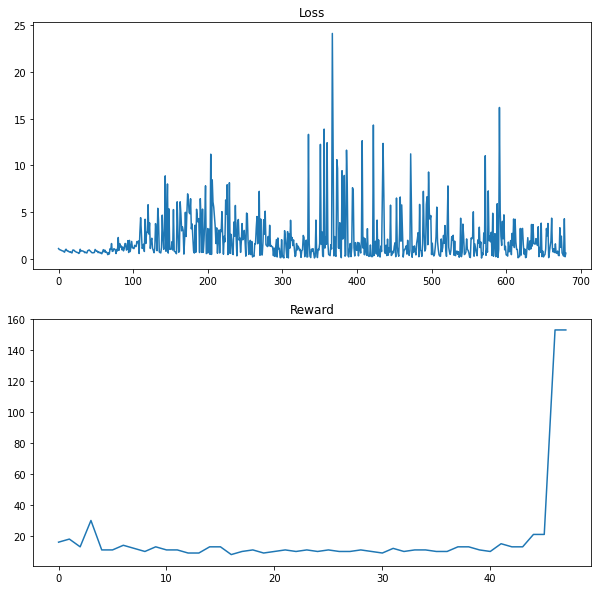

In [14]:
plt.figure(figsize=(10, 10))
charts=[losses,rewards]
titles=['Loss','Reward']
for i, (chart, title) in enumerate(zip(charts,titles)):
  ax=plt.subplot(2,1,i+1)
  plt.plot(chart)
  plt.title(title)